# VQEとVQE+HOAでHeisenberg Modelの基底エネルギーを求める

In [2]:
from openfermion.linalg import get_sparse_operator
from openfermion import QubitOperator
from qulacs.observable import create_observable_from_openfermion_text
from qulacs import QuantumState, QuantumCircuit
from qulacs.state import inner_product
from qulacs.gate import *
import numpy as np
from scipy.linalg import expm

def HeisenbergQubitOperator(J,h,N):
    """
    returns hamiotonian as openfermion.ops.operators.qubit_operator.QubitOperator
    """
    hamiltonian = QubitOperator()
    spin2_list = []
    spin1_list = []

    for i in range(N):
        spin1_list.append("Z{}".format(i))
    for i in range(N-1):
        for j in ["X","Y","Z"]:
            spin2_list.append("{}{} {}{}".format(j,i,j,i+1))
    for i in range(N):
        hamiltonian += -h*QubitOperator(spin1_list[i])
    for i in range(3*(N-1)):
        hamiltonian += -J*QubitOperator(spin2_list[i])
    return hamiltonian

def Heisenberg_Hamiltonian(J,h,N):
    """
    returns Heisenberg hamiltonian as array
    """
    hamiltonian = HeisenbergQubitOperator(J,h,N)
    hamiltonian = get_sparse_operator(hamiltonian).toarray()
    return hamiltonian

## VQE (No HOA)

In [3]:
J,h,N = 1,1,10
depth = 1
qulacs_hamiltonian = create_observable_from_openfermion_text(str(HeisenbergQubitOperator(J,h,N)))

def HE_Ansatz_Circuit(N,depth,theta_list):
    """
    Hardware Efficient Ansatz Circuit
    """
    circuit = QuantumCircuit(N)
    for d in range(depth):
        for i in range(N):
            circuit.add_gate(
                merge(
                    merge(RZ(i, theta_list[3*i+3*N*d]),RX(i, theta_list[3*i+1+3*N*d])),RZ(i, theta_list[3*i+2+2*N*d])
                     ))
        for i in range(N//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
        for i in range(N//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
    for i in range(N):
        circuit.add_gate(merge(RX(i, theta_list[2*i+3*N*depth]), RZ(i, theta_list[2*i+1+3*N*depth])))
    return circuit

def cost(theta_list):
    state = QuantumState(N)
    circuit = HE_Ansatz_Circuit(N, depth, theta_list)
    circuit.update_quantum_state(state)
    return qulacs_hamiltonian.get_expectation_value(state)

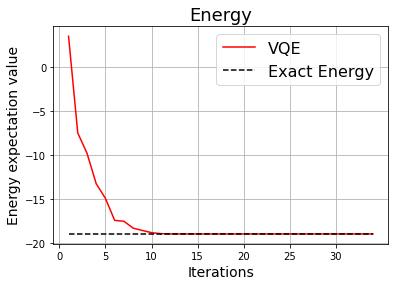

-19 -18.999999999804484


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

cost_history = []
init_theta_list = np.random.random(N*(3*depth+2))*2*np.pi
cost_history.append(cost(init_theta_list))
method = "BFGS"
options = {"disp": True, "maxiter": 100, "gtol": 1e-6}
opt = minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

exact_energy = -J*(N-1)-h*N
x = np.array([i+1 for i in range(len(cost_history))])
y = np.array(cost_history)
exact = np.array([exact_energy for i in range(len(cost_history))])

plt.plot(x,y,color='red',label='VQE')
plt.plot(x,exact,color='black',linestyle='--',label='Exact Energy')

plt.title('Energy',size=18)#title
plt.xlabel('Iterations',size=14)
plt.ylabel('Energy expectation value',size=14)
plt.grid()
plt.xticks([5*i for i in range(len(x)//5+1)])
plt.yticks()
plt.legend(fontsize=16, loc='upper right')
plt.show()

print(exact_energy,cost_history[-1])

### 考察
論文中では少なくともdepthが20くらいないと収束しないような書き方がされているがdepthが1でも収束している様子だった．論文ではADAM(3000itr,学習率=0.001)を使っているのに対して上の実装ではBFGSを使っていることが関係しているのだろうか？

## VQE+HOA

In [5]:
def exp_zz(theta,target,control):
    unitary = merge(CNOT(target,control),RZ(control,2*theta))
    unitary = merge(unitary,CNOT(target,control))
    return unitary

def exp_xx(theta,target,control):
    trans = merge(H(target),H(control))
    unitary = merge(trans,exp_zz(theta,target,control))
    unitary = merge(unitary,trans)
    return unitary

def exp_yy(theta,target,control):
    trans = merge(S(target),S(control))
    ZZ = merge(Z(target),Z(control))
    trans_conj = merge(ZZ,trans)
    unitary = merge(trans,exp_xx(theta,target,control))
    unitary = merge(unitary,trans_conj)
    return unitary

def T_Heisenberg_Gate(J,h,N,r,t):
    """
    returns: exponential of Heisenberg Hamiltonian as `qulacs.QuantumGateBase`
    """
    unitary = Identity(0)
    theta_J = J/(2*r)*t
    theta_h = h/r*t
    for step in range(r):
        for i in range(N-1):
            unitary = merge(unitary,exp_xx(theta_J,i,i+1))
            unitary = merge(unitary,exp_yy(theta_J,i,i+1))
            unitary = merge(unitary,exp_zz(theta_J,i,i+1))
        for i in range(N):
            unitary = merge(unitary,(RZ(i,theta_h*2)))
        for i in range(N-1):
            unitary = merge(unitary,exp_zz(theta_J,i,i+1))
            unitary = merge(unitary,exp_yy(theta_J,i,i+1))
            unitary = merge(unitary,exp_xx(theta_J,i,i+1))
    return unitary

def Derive_q(S:int):
    """
    solve Simultaneous equations
    returns vector q as numpy.array
    """
    s = (S-1)/2
    M = []
    D = [0]*S
    D[1] = 1
    for i in range(S):
        M.append([])
        for j in range(S):
            M[-1].append((-s+j)**(i))
    M = np.array(M)
    q = np.linalg.inv(M)@D
    return q

def Trotter_Heisenberg_HOA(J,h,N,r,s_max,delta):
    veq_q = Derive_q(S=s_max)
    s=(s_max-1)/2
    hamiltonian = veq_q[0]*T_Heisenberg_Gate(J,h,N,r,-s*delta).get_matrix()
    for i in range(1,s_max):
        hamiltonian += veq_q[i]*T_Heisenberg_Gate(J,h,N,r,(-s+i)*delta).get_matrix()
    return (1j/delta)*hamiltonian


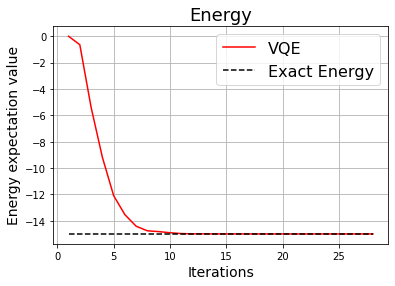

-15 -14.999999993902787


In [6]:
r,s_max,delta = 7,9,0.01
N=8
hamiltonain = DenseMatrix([i for i in range(N)],Trotter_Heisenberg_HOA(J,h,N,r,s_max,delta))

def cost_HOA(theta_list):
    bra = QuantumState(N)
    ket = QuantumState(N)
    circuit = HE_Ansatz_Circuit(N, depth, theta_list)
    circuit.update_quantum_state(bra)
    circuit.update_quantum_state(ket)
    hamiltonain.update_quantum_state(ket)
    return np.real(inner_product(bra,ket))


cost_history = []
init_theta_list = np.random.random(N*(3*depth+2))*2*np.pi
cost_history.append(cost(init_theta_list))
method = "BFGS"
options = {"disp": True, "maxiter": 100, "gtol": 1e-6}
opt = minimize(cost_HOA, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost_HOA(x)))

exact_energy = -J*(N-1)-h*N
x = np.array([i+1 for i in range(len(cost_history))])
y = np.array(cost_history)
exact = np.array([exact_energy for i in range(len(cost_history))])

plt.plot(x,y,color='red',label='VQE')
plt.plot(x,exact,color='black',linestyle='--',label='Exact Energy')

plt.title('Energy',size=18)#title
plt.xlabel('Iterations',size=14)
plt.ylabel('Energy expectation value',size=14)
plt.grid()
plt.xticks([5*i for i in range(len(x)//5+1)])
plt.yticks()
plt.legend(fontsize=16, loc='upper right')
plt.show()

print(exact_energy,cost_history[-1])